# Lab 6. CNN MNIST classification

### 이번 실습은 Convolutional Neural Network 모델을 만들고 이를 이용해 MNIST dataset으로 classification을 진행해보며 CNN의 사용방법을 익혀보겠습니다.

### 이 과정에서 CNN을 사용할 때와 MLP를 사용할 때 어떤 점이 다른지 비교해보면서 CNN의 특징을 살펴보도록 하겠습니다.

### 또한 흑백 이미지 데이터였던 MNIST 뿐만 아니라 칼라 이미지 데이터인 SVHN 데이터를 사용해서 본격적인 이미지 데이터 활용을 해보도록 하겠습니다.





### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import time

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 6-1. Review for the MNIST Dataset

### Data Prepare

In [3]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")

# torchvision 이 제공하는 dataset 불러오기
# https://pytorch.org/vision/stable/datasets 에서 class argument 들 확인 가능
mnist_train = datasets.MNIST(
    root=root,                         # 데이터를 읽어오거나 다운로드 할 경로
    train=True,                        # Train data
    download=True,                     # 자동으로 root에서 읽어오기 / 혹은 없다면 다운로드
    transform=transforms.ToTensor()    # pytorch Tensor 형태의 data로 변환
)
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) 

### Train / Val Split

In [6]:
# data 와 target 를 같이 다루는 Dataset class
# idx 를 주면 해당하는 data, target pair 를 transfom 시킨 값을 뱉어냄
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]
    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [7]:
# Train dataset을 쪼개서 validation dataset을 만드는 함수
# valid_ratio 만큼의 비율의 데이터를 valid data로 만듦
def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset) * valid_ratio)         # valid data 개수
  
  train_data = np.array(dataset.data[:-n_valid])      # dataset 중에 뒤에서부터 n_valid 개만큼 뺀 나머지를 train data로 만듦
  valid_data = np.array(dataset.data[-n_valid:])      # dataset 중에 뒤에서부터 n_valid 개만큼을 valid data로 만듦
  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  # train / valid 로 쪼갠 data, target 들을 pair로 엮어서 다루기 위해 dataset class 로 정의해줌
  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

In [8]:
print(mnist_train)      # train/val 로 쪼개기 전 데이터 확인
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)    # torvision dataset에서 불러온 train dataset을 train / val 로 쪼갬

# DataLoader 정의
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)    # train 시에는 데이터를 shuffle 해줌
valid_loader = DataLoader(dataset=mnist_valid, batch_size=64, shuffle=False, drop_last=True)   
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()


### Data Check

In [9]:
sample_x, sample_y = mnist_train[0]     # train 데이터 example: x=이미지, y=label
print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
tensor(5)


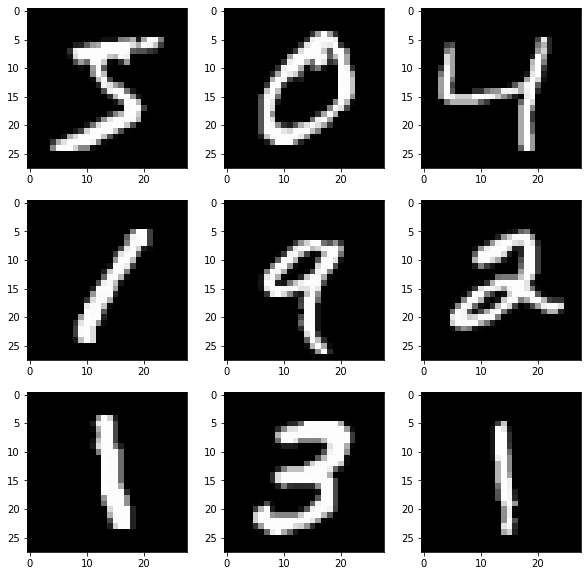

In [10]:
# train data example visualization
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  img = mnist_train[i][0]
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img.reshape(28, 28), cmap="gray")
fig.show()

## 6-2. CNN Classification


### Simple CNN Model

In [22]:
## 간단한 CNN Classifier 모델

class Lion_MNIST_CNN_Classifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    ## filter visulaization 을 위해 layer 마다 따로 정의
    ## nn.Conv2d : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d
    ## nn.Maxpool2d : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(3*3*32, 32)
    self.fc2 = nn.Linear(32, 10)         # classification을 수행할 label 은 총 10가지


    ## nn.Sequential 을 사용하면 더 깔끔하게 network를 정의할 수 있음

    # self.model = nn.Sequential(
    #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
    #     nn.ReLU(),
    #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Flatten(),
    #     nn.Linear(3*3*32, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 10),
    # )

    
  def forward(self, x, visualize_filter=False):
    conv1 = self.conv1(x)
    _conv1 = self.pool(self.relu(conv1))
    conv2 = self.conv2(_conv1)
    _conv2 = self.pool(self.relu(conv2))
    conv3 = self.conv3(_conv2)
    _conv3 = self.pool(self.relu(conv3))
    conv3_vec = self.flatten(_conv3)
    fc1 = self.fc1(conv3_vec)
    out = self.fc2(self.relu(fc1))

    ## nn.Sequential 을 사용할 경우
    # out = self.mode(x)

    if not visualize_filter:    # 일반적인 경우
      return out
    else:                       # visualzie_filter = True --> conv filter 가 생긴 것을 보고 싶을 때
      return conv1, conv2, conv3,out

In [23]:
cnn = Lion_MNIST_CNN_Classifier()

In [24]:
## CNN 구조를 확인하기 위한 테스트 데이터
sample_x = mnist_valid[0][0].unsqueeze(dim=0)    # unsqeeze : 데이터를 1차원 확장 --> dim 에 해당하는 차원으로
print(sample_x.shape)                            # CNN의 input 이 (batch, channels, H, W) 꼴이므로 맞춰주기 위해 (batch=1)로 차원을 확장

torch.Size([1, 1, 28, 28])


In [25]:
conv1, conv2, conv3,out = cnn(sample_x, visualize_filter=True)
print(conv1.shape, conv2.shape, conv3.shape, out.shape)

torch.Size([1, 32, 28, 28]) torch.Size([1, 32, 14, 14]) torch.Size([1, 32, 7, 7]) torch.Size([1, 10])


### Training CNN

In [26]:
start_time = time.time()      # 현재 시각을 기록
start_time

1636809097.5698502

In [27]:
time_interval = time.time() - start_time     # start_time에서 지금까지 얼마나 시간이 흘렀는지를 초로 표현
time_interval

50.939955711364746

In [28]:
## Trainer class 정의

class Trainer(nn.Module):
  def __init__(self, model, opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
    """
      Args:
        model: 사용할 classification model
        n_class: class 개수
        opt: optimizer
        lr: learning rate
        has_scheduler: learning rate scheduler 사용 여부
        device: 사용할 device (cpu/cuda)
    """
    super().__init__()

    self.model = model                            # class 개수를 input으로 classification model 정의
    self.loss = nn.CrossEntropyLoss()             # loss function 정의
    
    self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
    self.has_scheduler = has_scheduler            # scheduler 사용여부 
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device                          # 사용할 device

  def _get_optimizer(self, opt, lr=0.001):
    """
      Args:
        opt: optimizer
        lr: learning rate
    """
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
#     self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
    self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

  def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5):
    """
      네트워크를 학습시키는 함수
      Args:
        train_loader: 학습에 사용할 train dataloader
        valid_loader: validation에 사용할 dataloader
        max_epochs: 학습을 진행할 총 epoch 수
        disp_epochs: 학습 log를 display 할 epoch 주기
    """
    print("===== Train Start =====")
    start_time = time.time()   
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch(train_loader)
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
      history["train_acc"].append(train_acc)        #
      history["valid_loss"].append(valid_loss)      #
      history["valid_acc"].append(valid_acc)        #

      if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
        self.scheduler.step()

      if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}, time: {time.time()-start_time:>3f}")
        start_time = time.time()   

    self.plot_history(history)       # 그래프 출력

  def _train_epoch(self, train_loader):
    """
      model를 training set 한 epoch 만큼 학습시키는 함수
      Args:
        train_loader: 학습에 사용할 train dataloader
      Returns:
        training set 한 epoch의 평균 loss, 평균 accuracy
    """
    epoch_loss, epoch_acc = 0, 0
    self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
    for (x, y) in train_loader:        # x: data, y:label
        
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)            # model이 예측한 label 
      loss = self.loss(y_hat, y)       

      self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
      loss.backward()                  # 
      self.optimizer.step()            # 

      epoch_loss += loss.to("cpu").item()    
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(train_loader)  
    epoch_acc /= len(train_loader)

    return epoch_loss, epoch_acc
  
  def _valid_epoch(self, valid_loader):
    """
      현재 model의 성능을 validation set에서 측정하는 함수
      Args:
        valid_loader: 학습에 사용할 valid dataloader
      Returns:
        validation set 의 평균 loss, 평균 accuracy
    """
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
    with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
      for (x, y) in valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(valid_loader)
    epoch_acc /= len(valid_loader)

    return epoch_loss, epoch_acc

  def plot_history(self, history):
    """
      history에 저장된 model의 성능을 graph로 plot
      Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
                 각 item 들은 epoch 단위의 성능 history의 list
    """
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()

  def test(self, test_loader):
    """
      현재 model의 성능을 test set에서 측정하는 함수
      Args:
        test_loader: 학습에 사용할 test dataloader
      Returns:
        test set 의 평균 loss, 평균 accuracy
    """
    print("===== Test Start =====")
    start_time = time.time()
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
    with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
      for (x, y) in test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(test_loader)
    epoch_acc /= len(test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}, time: {time.time()-start_time:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.330485, train acc: 0.890996, valid loss: 0.090599, valid acc: 0.972950, time: 7.722900
Epoch: 1, train loss: 0.083157, train acc: 0.973291, valid loss: 0.066634, valid acc: 0.980007, time: 7.667680
Epoch: 2, train loss: 0.059173, train acc: 0.981428, valid loss: 0.061276, valid acc: 0.980679, time: 7.685095
Epoch: 3, train loss: 0.045414, train acc: 0.985932, valid loss: 0.045175, valid acc: 0.987735, time: 7.646721
Epoch: 4, train loss: 0.040337, train acc: 0.987026, valid loss: 0.038754, valid acc: 0.989751, time: 7.590599
Epoch: 5, train loss: 0.032772, train acc: 0.989769, valid loss: 0.043024, valid acc: 0.987399, time: 7.551289
Epoch: 6, train loss: 0.030176, train acc: 0.990529, valid loss: 0.037065, valid acc: 0.990087, time: 7.550809
Epoch: 7, train loss: 0.026508, train acc: 0.991733, valid loss: 0.026998, valid acc: 0.993448, time: 7.560541
Epoch: 8, train loss: 0.022878, train acc: 0.992530, valid loss: 0.038596, valid acc: 0.

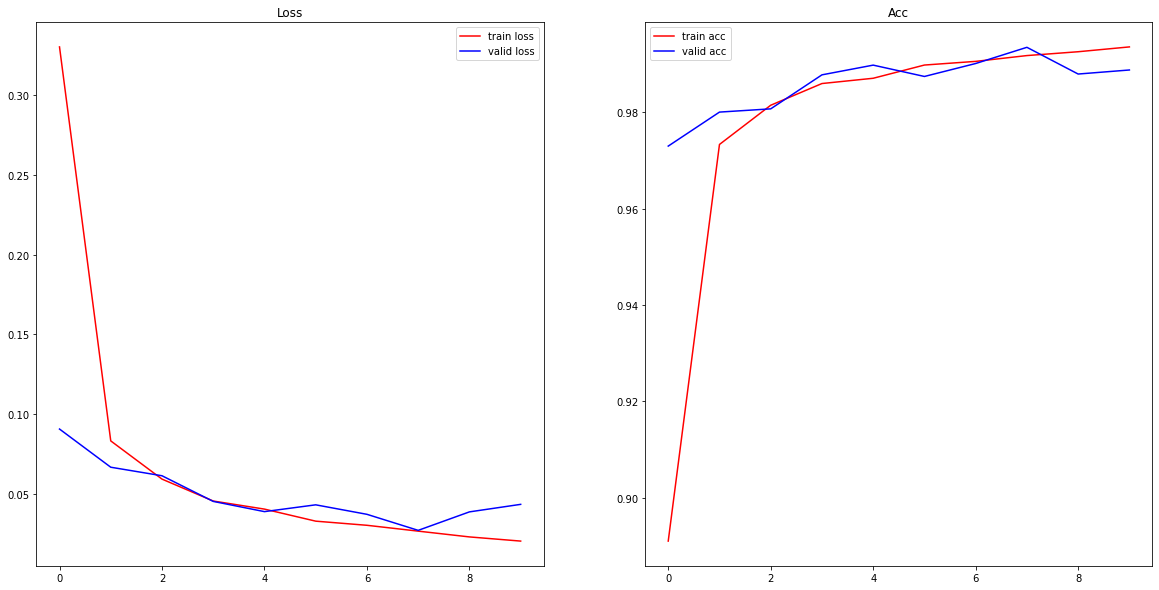

In [29]:
device = "cuda"
cnn = Lion_MNIST_CNN_Classifier(n_class=10)
trainer = Trainer(model=cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(test_loader)

### Model Save/Load

In [30]:
## State dict
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in cnn.state_dict():
    print(f"{param_tensor}, \t {cnn.state_dict()[param_tensor].size()}")

Model's state_dict:
conv1.weight, 	 torch.Size([32, 1, 5, 5])
conv1.bias, 	 torch.Size([32])
conv2.weight, 	 torch.Size([32, 32, 3, 3])
conv2.bias, 	 torch.Size([32])
conv3.weight, 	 torch.Size([32, 32, 3, 3])
conv3.bias, 	 torch.Size([32])
fc1.weight, 	 torch.Size([32, 288])
fc1.bias, 	 torch.Size([32])
fc2.weight, 	 torch.Size([10, 32])
fc2.bias, 	 torch.Size([10])


In [31]:
# Save
model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
torch.save(cnn.state_dict(), os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth"))

In [32]:
# 학습되지 않은 model test 성능

device = "cuda"
cnn_load = Lion_MNIST_CNN_Classifier(n_class=10)
trainer_not_load = Trainer(model=cnn_load, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_not_load.test(test_loader)

===== Test Start =====
Test loss: 2.308912, Test acc: 0.100962, time: 1.685786


In [33]:
# Load model

model_path = os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth")
print(model_path)
cnn_load.load_state_dict(torch.load(model_path))
cnn_load.eval()

/content/drive/MyDrive/Colab Notebooks/model/Lion_MNIST_CNN_Classifier.pth


Lion_MNIST_CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=cnn_load, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(test_loader)

===== Test Start =====
Test loss: 0.029480, Test acc: 0.991386, time: 1.702245


### CNN과 MLP 비교

In [35]:
class Lion_MNIST_MLP_Classifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [37]:
mlp = Lion_MNIST_MLP_Classifier(n_class=10)

In [38]:
def count_parameters(model):
    """
        model의 총 parameter 수와 그 배치를 print 하는 함수
        Args:
            model: 분석할 model
    
    """
    total_parameters = 0
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        total_parameters += model.state_dict()[param_tensor].numel()
        print(f"{param_tensor}".center(20), f"{model.state_dict()[param_tensor].size()}".ljust(30), f"{model.state_dict()[param_tensor].numel()}")
    
    print(f"Model's total parameters : {total_parameters}")
    return 

In [39]:
count_parameters(cnn)
count_parameters(mlp)

Model's state_dict:
    conv1.weight     torch.Size([32, 1, 5, 5])      800
     conv1.bias      torch.Size([32])               32
    conv2.weight     torch.Size([32, 32, 3, 3])     9216
     conv2.bias      torch.Size([32])               32
    conv3.weight     torch.Size([32, 32, 3, 3])     9216
     conv3.bias      torch.Size([32])               32
     fc1.weight      torch.Size([32, 288])          9216
      fc1.bias       torch.Size([32])               32
     fc2.weight      torch.Size([10, 32])           320
      fc2.bias       torch.Size([10])               10
Model's total parameters : 28906
Model's state_dict:
   model.1.weight    torch.Size([256, 784])         200704
    model.1.bias     torch.Size([256])              256
   model.3.weight    torch.Size([128, 256])         32768
    model.3.bias     torch.Size([128])              128
   model.5.weight    torch.Size([10, 128])          1280
    model.5.bias     torch.Size([10])               10
Model's total parameters : 2

===== Train Start =====
Epoch: 0, train loss: 0.011680, train acc: 0.996052, valid loss: 0.114787, valid acc: 0.978327, time: 3.983238
Epoch: 1, train loss: 0.011047, train acc: 0.996274, valid loss: 0.115626, valid acc: 0.979335, time: 3.880137
Epoch: 2, train loss: 0.007809, train acc: 0.997183, valid loss: 0.110236, valid acc: 0.980175, time: 3.853289
Epoch: 3, train loss: 0.009471, train acc: 0.996997, valid loss: 0.118720, valid acc: 0.981351, time: 3.868097
Epoch: 4, train loss: 0.009649, train acc: 0.996923, valid loss: 0.108428, valid acc: 0.980343, time: 3.920976
Epoch: 5, train loss: 0.007882, train acc: 0.997442, valid loss: 0.136584, valid acc: 0.978999, time: 3.896291
Epoch: 6, train loss: 0.010623, train acc: 0.996571, valid loss: 0.112291, valid acc: 0.982023, time: 3.846833
Epoch: 7, train loss: 0.004998, train acc: 0.998443, valid loss: 0.126307, valid acc: 0.980007, time: 3.863951
Epoch: 8, train loss: 0.007718, train acc: 0.997553, valid loss: 0.116173, valid acc: 0.

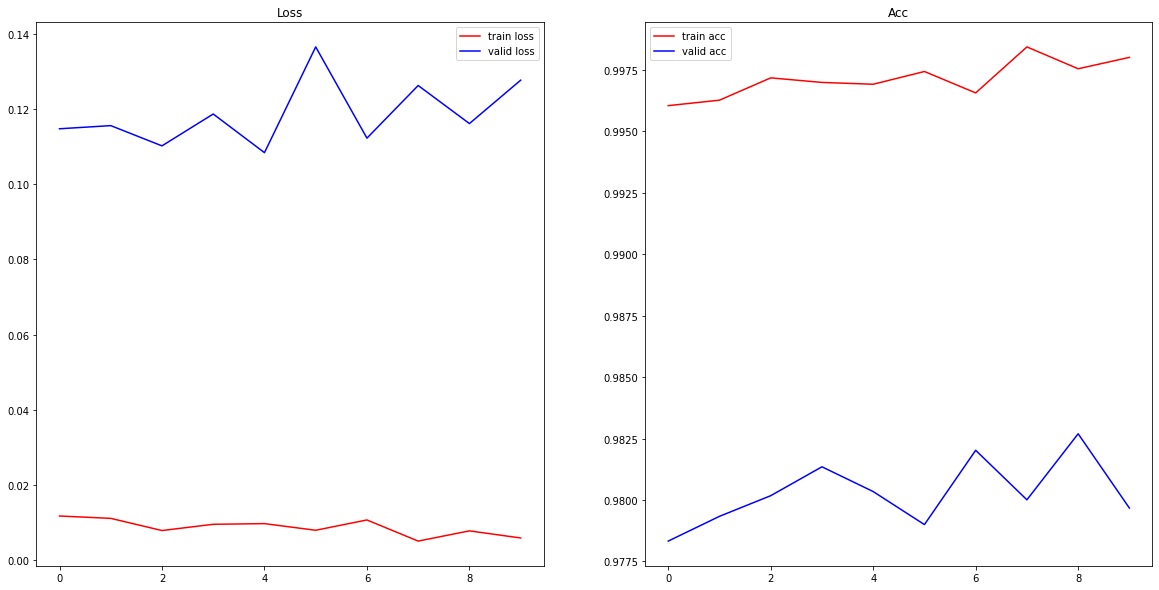

In [41]:
device = "cuda"
trainer_mlp = Trainer(model=mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_mlp.test(test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
torch.save(mlp.state_dict(), os.path.join(model_dir, "Lion_MNIST_MLP_Classifier.pth"))

In [42]:
class Lion_MNIST_MLP_Classifier_mini(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 33),
        nn.ReLU(),
        nn.Linear(33, 64),
        nn.ReLU(),
        nn.Linear(64, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [45]:
mlp_mini = Lion_MNIST_MLP_Classifier_mini(n_class=10)
count_parameters(mlp_mini)

Model's state_dict:
   model.1.weight    torch.Size([33, 784])          25872
    model.1.bias     torch.Size([33])               33
   model.3.weight    torch.Size([64, 33])           2112
    model.3.bias     torch.Size([64])               64
   model.5.weight    torch.Size([10, 64])           640
    model.5.bias     torch.Size([10])               10
Model's total parameters : 28731


===== Train Start =====
Epoch: 0, train loss: 0.061941, train acc: 0.980557, valid loss: 0.093150, valid acc: 0.973958, time: 3.929656
Epoch: 1, train loss: 0.055203, train acc: 0.982299, valid loss: 0.104126, valid acc: 0.969086, time: 3.953899
Epoch: 2, train loss: 0.050609, train acc: 0.984097, valid loss: 0.100572, valid acc: 0.974126, time: 3.991768
Epoch: 3, train loss: 0.045883, train acc: 0.985617, valid loss: 0.095569, valid acc: 0.975302, time: 3.943567
Epoch: 4, train loss: 0.042810, train acc: 0.986228, valid loss: 0.097705, valid acc: 0.972278, time: 3.912807
Epoch: 5, train loss: 0.040340, train acc: 0.987229, valid loss: 0.095831, valid acc: 0.974630, time: 3.933592
Epoch: 6, train loss: 0.035809, train acc: 0.988916, valid loss: 0.100947, valid acc: 0.973118, time: 3.968346
Epoch: 7, train loss: 0.034183, train acc: 0.988935, valid loss: 0.106525, valid acc: 0.973286, time: 3.894364
Epoch: 8, train loss: 0.032243, train acc: 0.989138, valid loss: 0.111875, valid acc: 0.

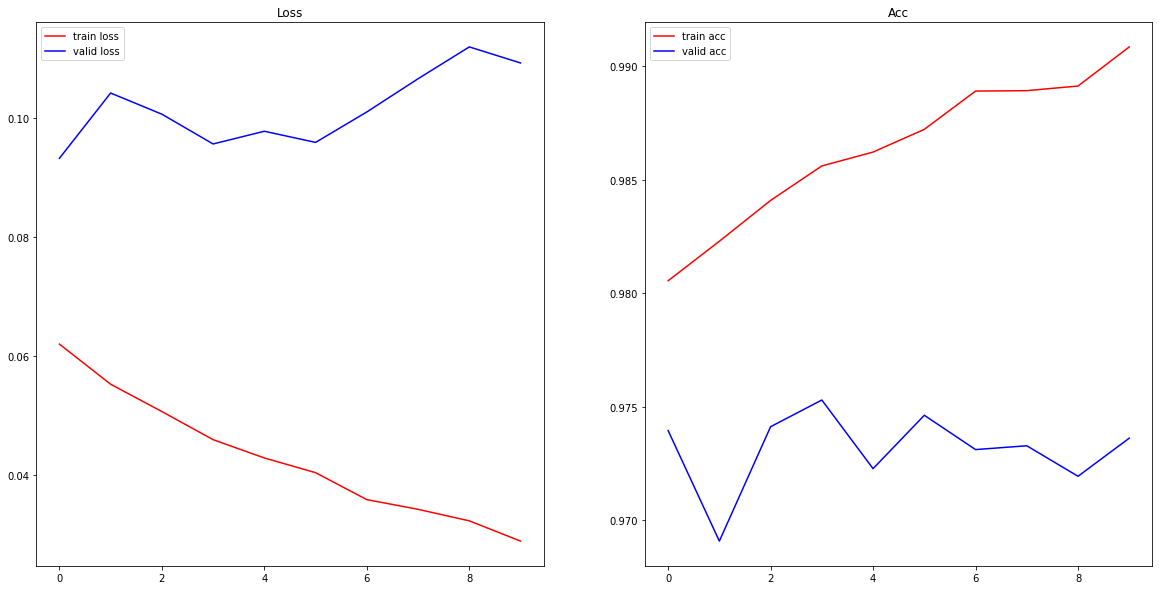

In [47]:
trainer_mlp_mini = Trainer(model=mlp_mini, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp_mini.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_mlp_mini.test(test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
torch.save(mlp_mini.state_dict(), os.path.join(model_dir, "Lion_MNIST_MLP_Classifier_mini.pth"))

### CPU vs GPU
CPU : 명령어가 입력된 순서대로 데이터를 처리하는 직렬 처리 방식에 특화된 구조 --> 한 번에 한 가지의 명령만 처리함
GPU : 여러 명령어를 동시에 처리하는 병렬 처리 방식에 특화된 구조 --> 연산을 할 수 있는 코어가 많음

CNN : Convolution 연산 시 동일한 filter 값으로 픽셀을 옮겨가며 연산을 반복함

따라서 CNN은 병렬 처리에 강점이 있는 GPU를 사용하는 것이 유리하다

In [48]:
# CNN CPU 학습속도
device = "cpu"
cnn = Lion_MNIST_CNN_Classifier(n_class=10)
trainer = Trainer(model=cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.308428, train acc: 0.902098, valid loss: 0.105438, valid acc: 0.969926, time: 45.281561


KeyboardInterrupt: ignored

In [49]:
# CPU CNN inference 속도
trainer.test(test_loader)

===== Test Start =====
Test loss: 0.064983, Test acc: 0.977865, time: 4.361212


In [51]:
# CPU MLP 학습속도
mlp_mini = Lion_MNIST_MLP_Classifier_mini(n_class=10)
trainer_mlp_mini = Trainer(model=mlp_mini, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp_mini.train(train_loader, valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.433240, train acc: 0.879430, valid loss: 0.179649, valid acc: 0.949429, time: 3.196258
Epoch: 1, train loss: 0.197876, train acc: 0.942653, valid loss: 0.138766, valid acc: 0.960181, time: 3.276193
Epoch: 2, train loss: 0.154293, train acc: 0.954126, valid loss: 0.115980, valid acc: 0.967070, time: 3.204496
Epoch: 3, train loss: 0.129091, train acc: 0.961077, valid loss: 0.116100, valid acc: 0.968078, time: 3.223062


KeyboardInterrupt: ignored

In [52]:
# CPU MLP inference 속도
trainer_mlp_mini.test(test_loader)

===== Test Start =====
Test loss: 0.119684, Test acc: 0.964443, time: 1.273035


### Filter, Feature map visualization

In [53]:
## 학습된 CNN Load

model_path = os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth")
print(model_path)
cnn.load_state_dict(torch.load(model_path))
cnn.to(device)
cnn.eval()


/content/drive/MyDrive/Colab Notebooks/model/Lion_MNIST_CNN_Classifier.pth


Lion_MNIST_CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

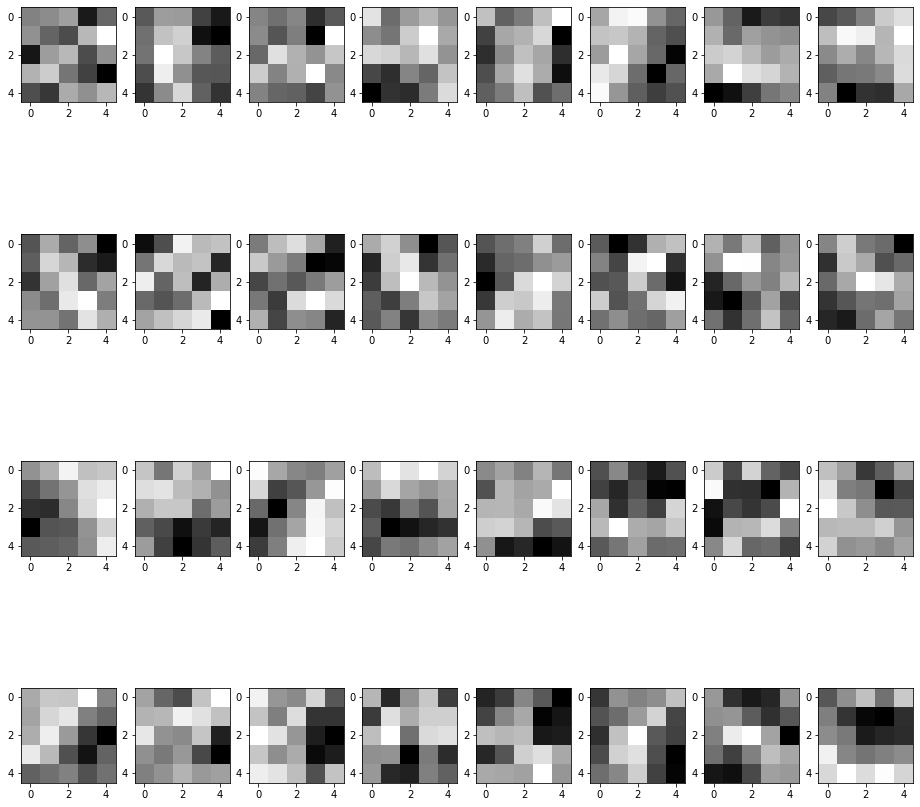

In [57]:
## 학습된 CNN의 첫번째 conv layer filter 를 visualization

conv_filter = np.array(cnn.state_dict()['conv1.weight'].data.to("cpu"))
fig = plt.figure(figsize=(16, 16))
for i in range(32):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(conv_filter[i, 0], cmap="gray")
fig.show()

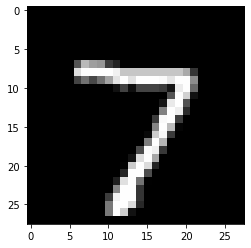

7


In [58]:
## Sample Image 
sample_x, sample_y = mnist_test[0]  
f1, f2, f3, out = cnn(sample_x.unsqueeze(0).to(device), visualize_filter=True)

fig0 = plt.figure()
plt.imshow(np.array(sample_x.to("cpu").detach())[0], cmap="gray")
plt.show()
print(np.argmax(np.array(out.to("cpu").detach())))

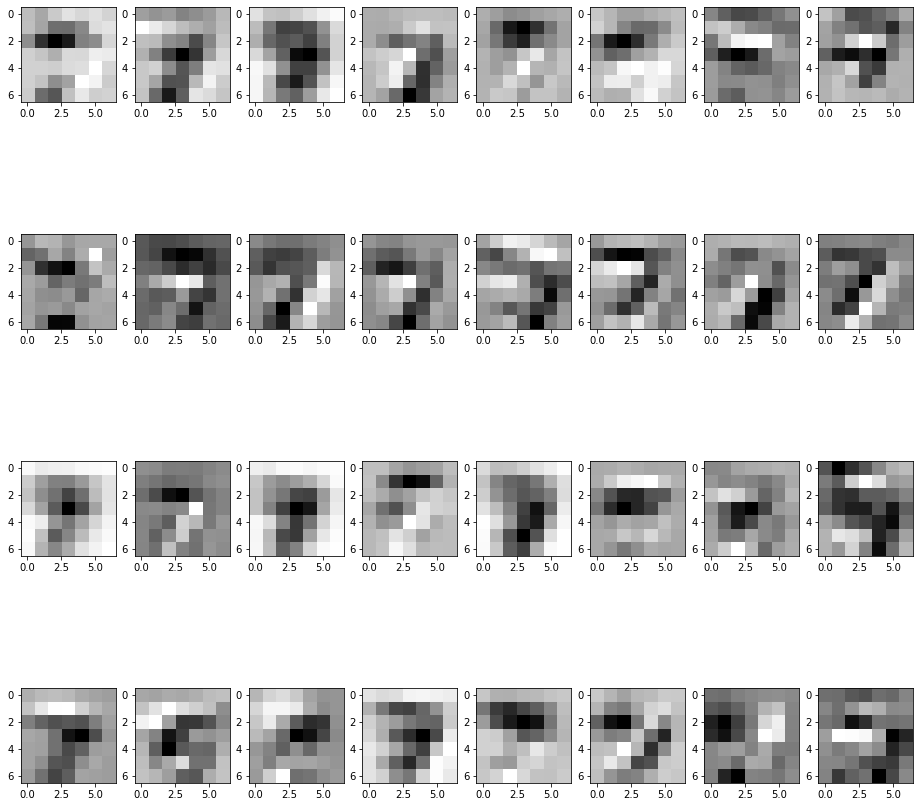

In [62]:
## Sample Image 에 대해 feature map visualization

fig = plt.figure(figsize=(16, 16))
for i in range(32):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(np.array(f3.to("cpu").detach())[0, i], cmap="gray")
fig.show()

## 6-3. SVHN
The Street View House Number (SVHN) Dataset

MNIST 와 유사하게 0 ~ 9 의 이미지와 label 로 구성되어 있음

입력 이미지는 32x32x3 RGB 이미지

### Data load

In [63]:
SVHN_train = datasets.SVHN(
    root=root, 
    split='train', 
    download=True, 
    transform=transforms.ToTensor()
) 
SVHN_test = datasets.SVHN(
    root=root, 
    split='test', 
    download=True, 
    transform=transforms.ToTensor()
) 

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [64]:
print(SVHN_train)
print(SVHN_train[0])
sample_x, sample_y = SVHN_train[0]
print(sample_x.shape)
print(sample_y)

Dataset SVHN
    Number of datapoints: 73257
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: train
    StandardTransform
Transform: ToTensor()
(tensor([[[0.1294, 0.0588, 0.0588,  ..., 0.2824, 0.3216, 0.3490],
         [0.1098, 0.0549, 0.0549,  ..., 0.1569, 0.2627, 0.3255],
         [0.1569, 0.0706, 0.0627,  ..., 0.0902, 0.1373, 0.2824],
         ...,
         [0.3373, 0.3412, 0.3216,  ..., 0.4078, 0.4078, 0.4039],
         [0.3294, 0.3373, 0.3216,  ..., 0.4314, 0.4157, 0.4157],
         [0.3333, 0.3490, 0.3333,  ..., 0.4353, 0.4275, 0.4039]],

        [[0.1176, 0.0902, 0.0667,  ..., 0.2549, 0.3020, 0.3098],
         [0.1529, 0.0980, 0.0784,  ..., 0.1529, 0.2275, 0.3059],
         [0.1608, 0.0824, 0.0667,  ..., 0.1137, 0.1647, 0.2706],
         ...,
         [0.3176, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4118],
         [0.3373, 0.3098, 0.2980,  ..., 0.4039, 0.4118, 0.4078],
         [0.3451, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4157]],

        [[0.1490, 

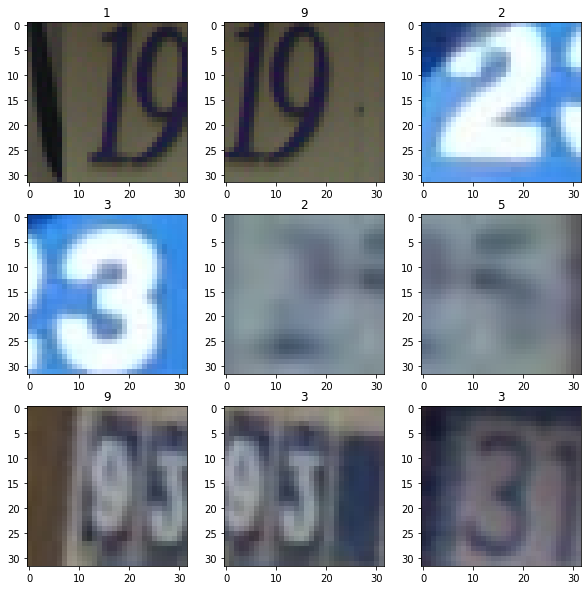

In [65]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  img = SVHN_train[i][0]
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img.permute(1, 2, 0))
  ax.title.set_text(SVHN_train[i][1])
fig.show()

In [66]:
# SVHN DataLoader 생성

from torch.utils.data import random_split

random_seed = 0
torch.manual_seed(random_seed)

val_size = int(len(SVHN_train) * 0.1)
train_size = len(SVHN_train) - val_size

SVHN_train, SVHN_valid = random_split(SVHN_train, [train_size, val_size])
print(len(SVHN_train), len(SVHN_valid))

# DataLoader 정의
SVHN_train_loader = DataLoader(dataset=SVHN_train, batch_size=64, shuffle=True, drop_last=True)    # train 시에는 데이터를 shuffle 해줌
SVHN_valid_loader = DataLoader(dataset=SVHN_valid, batch_size=64, shuffle=False, drop_last=True)   
SVHN_test_loader = DataLoader(dataset=SVHN_test, batch_size=64, shuffle=False, drop_last=True)

65932 7325


In [67]:
## 간단한 CNN, MLP Classifier 모델

class Lion_SVHN_CNN_Classifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

    
  def forward(self, x, visualize_filter=False):

    out = self.model(x)

    return out

class Lion_SVHN_MLP_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2048),
        nn.ReLU(),
        nn.Linear(1024, 10),
    )

  def forward(self, x):
    return self.model(x)


In [68]:
svhn_cnn = Lion_SVHN_CNN_Classifier()
svhn_mlp = Lion_SVHN_MLP_Classifier()

count_parameters(svhn_cnn)
count_parameters(svhn_mlp)

Model's state_dict:
   model.0.weight    torch.Size([32, 3, 3, 3])      864
    model.0.bias     torch.Size([32])               32
   model.2.weight    torch.Size([64, 32, 3, 3])     18432
    model.2.bias     torch.Size([64])               64
   model.5.weight    torch.Size([128, 64, 3, 3])    73728
    model.5.bias     torch.Size([128])              128
   model.7.weight    torch.Size([128, 128, 3, 3])   147456
    model.7.bias     torch.Size([128])              128
  model.10.weight    torch.Size([256, 128, 3, 3])   294912
   model.10.bias     torch.Size([256])              256
  model.12.weight    torch.Size([256, 256, 3, 3])   589824
   model.12.bias     torch.Size([256])              256
  model.16.weight    torch.Size([512, 4096])        2097152
   model.16.bias     torch.Size([512])              512
  model.18.weight    torch.Size([512, 512])         262144
   model.18.bias     torch.Size([512])              512
  model.20.weight    torch.Size([10, 512])          5120
   model.

===== Train Start =====
Epoch: 0, train loss: 1.942471, train acc: 0.304870, valid loss: 0.727485, valid acc: 0.766447, time: 14.033166
Epoch: 1, train loss: 0.483884, train acc: 0.849560, valid loss: 0.379377, valid acc: 0.885965, time: 14.089141
Epoch: 2, train loss: 0.329814, train acc: 0.900895, valid loss: 0.342588, valid acc: 0.896519, time: 14.153328
Epoch: 3, train loss: 0.276805, train acc: 0.917612, valid loss: 0.306816, valid acc: 0.911184, time: 14.139724
Epoch: 4, train loss: 0.237297, train acc: 0.928944, valid loss: 0.301749, valid acc: 0.912966, time: 14.130924
Epoch: 5, train loss: 0.210113, train acc: 0.937363, valid loss: 0.288881, valid acc: 0.915159, time: 14.096857
Epoch: 6, train loss: 0.185347, train acc: 0.945191, valid loss: 0.293138, valid acc: 0.916530, time: 14.112339
Epoch: 7, train loss: 0.162854, train acc: 0.951502, valid loss: 0.296741, valid acc: 0.920916, time: 14.130677
Epoch: 8, train loss: 0.144765, train acc: 0.956280, valid loss: 0.303684, valid

/home/hwing/.local/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Test loss: 0.600224, Test acc: 0.910137, time: 3.156474


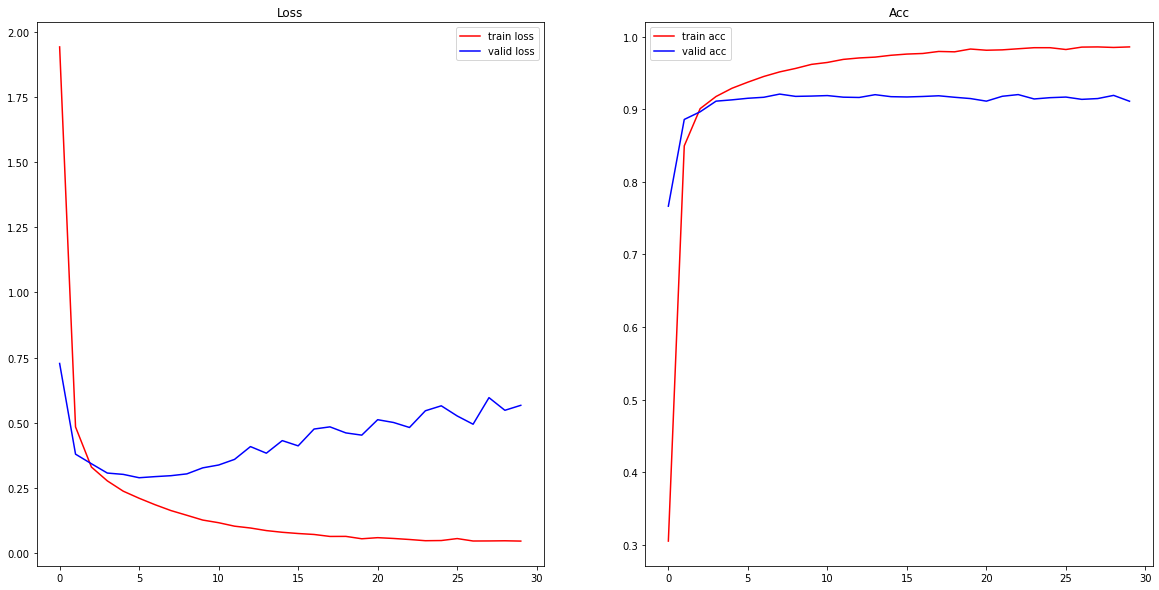

In [ ]:
device = "cuda"
trainer_svhn_cnn = Trainer(model=svhn_cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_svhn_cnn.train(SVHN_train_loader, SVHN_valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_svhn_cnn.test(SVHN_test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    
torch.save(svhn_cnn.state_dict(), os.path.join(model_dir, "Lion_SVHN_CNN_Classifier.pth"))

In [ ]:
model_path = os.path.join(model_dir, "Lion_SVHN_CNN_Classifier.pth")
print(model_path)
svhn_cnn.load_state_dict(torch.load(model_path))
svhn_cnn.eval()

# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=svhn_cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(SVHN_test_loader)

/home/hwing/Dataset2/Untitled Folder/drive/MyDrive/Colab Notebooks/model/Lion_SVHN_CNN_Classifier.pth
===== Test Start =====
Test loss: 0.600224, Test acc: 0.910137, time: 3.265933


===== Train Start =====
Epoch: 0, train loss: 2.238998, train acc: 0.189624, valid loss: 2.242657, valid acc: 0.182566, time: 9.100610
Epoch: 1, train loss: 2.236977, train acc: 0.189988, valid loss: 2.242391, valid acc: 0.182566, time: 9.110388
Epoch: 2, train loss: 2.236694, train acc: 0.189988, valid loss: 2.243367, valid acc: 0.182566, time: 9.123327
Epoch: 3, train loss: 2.236847, train acc: 0.189988, valid loss: 2.241861, valid acc: 0.182566, time: 9.148833
Epoch: 4, train loss: 2.236841, train acc: 0.189973, valid loss: 2.242287, valid acc: 0.182566, time: 9.163174
Epoch: 5, train loss: 2.236490, train acc: 0.189988, valid loss: 2.242129, valid acc: 0.182566, time: 9.141002
Epoch: 6, train loss: 2.236608, train acc: 0.190003, valid loss: 2.242553, valid acc: 0.182566, time: 9.112025
Epoch: 7, train loss: 2.236694, train acc: 0.189988, valid loss: 2.242021, valid acc: 0.182566, time: 9.043180
Epoch: 8, train loss: 2.236455, train acc: 0.189942, valid loss: 2.242696, valid acc: 0.

/home/hwing/.local/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Test loss: 2.224270, Test acc: 0.195851, time: 2.366526


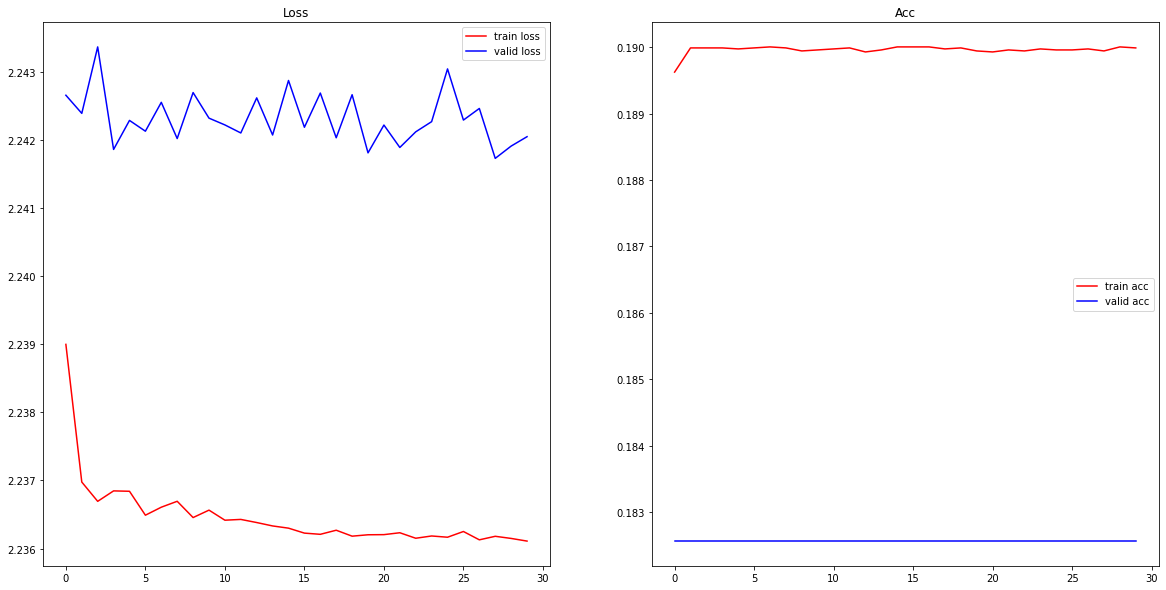

In [ ]:
trainer_svhn_mlp = Trainer(model=svhn_mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_svhn_mlp.train(SVHN_train_loader, SVHN_valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_svhn_mlp.test(SVHN_test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    
torch.save(svhn_mlp.state_dict(), os.path.join(model_dir, "Lion_SVHN_MLP_Classifier.pth"))

In [ ]:
model_path = os.path.join(model_dir, "Lion_SVHN_MLP_Classifier.pth")
print(model_path)
svhn_mlp.load_state_dict(torch.load(model_path))
svhn_mlp.eval()

# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=svhn_mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(SVHN_test_loader)

/home/hwing/Dataset2/Untitled Folder/drive/MyDrive/Colab Notebooks/model/Lion_SVHN_MLP_Classifier.pth
===== Test Start =====
Test loss: 2.224270, Test acc: 0.195851, time: 2.434202
